# PSF Experiment 2.0 - amc vs ngmix -  Moments + fixnoise

This notebook serves as a unit test base between amc and ngmix.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#utilities
from multiprocessing import Pool
from scipy.stats import linregress
import tqdm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf

#...vs them!
import ngmix
import galsim

## Settings

In [4]:
rng = np.random.RandomState(31415)

#stamp properties
stamp_size = 51
batch_size = 200
scale = 0.263
window_fwhm = 1.2
#computation settings
ncpus = 48

#test settings
g_psf =  array([0.01,0.0],dtype='float32')
noise_level = 1e-2
fixnoise = True
shapenoise = False
finitediff= False
psf_noise_level = noise_level/1000

#filenames
if finitediff:
  finitechoice = "finitediff"
else:
  finitechoice = "amc"
results_folder = f"Results/{finitechoice}_vs_ngmix"
settings_name = f"iso_vs_aniso_psf_{str(noise_level)}"

#build filename
if shapenoise:
  settings_name += "_shaped"
else:
  settings_name += "_round"
  
if fixnoise:
  settings_name += "_fixnoise"
else:
  settings_name += "_nofixnoise"  

## Get to the Data!

In [5]:
if shapenoise:
  data = tfds.load('GalGen/small_100k')
else:
  data = tfds.load('simple/small_1k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.repeat()
data = data.prefetch(tf.data.experimental.AUTOTUNE)

## Create observations

In [6]:
def make_psf(batch_size,stamp_size,g_psf,psf_fwhm = 0.7):
  '''make a simple batch of constant psfs with Moffat profiles'''
  psf = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_images = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method='no_pixel').array
  psf_images = tf.convert_to_tensor(psf_images,dtype=tf.float32)[tf.newaxis]
  psf_images = tf.repeat(psf_images,batch_size,axis=0)
  return psf_images

def make_noise(noise_level,batch_size,stamp_size):
  '''make a simple gaussian noise stamp'''
  noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  return noise_imgs

def observer(batch,shear_true,g_psf,noise_level,symmetric=True):
  '''creates observations for ngmix and amc'''

  psf_images = make_psf(batch_size,stamp_size,g_psf)
  gal_images = amc.noiseless_real_mcal_image(
    onebatch['gal_model'],
    psf_images,
    tf.repeat([shear_true], len(onebatch['gal_model']),axis=0)
  )
  
  #add noise
  noise_images = make_noise(noise_level,batch_size,stamp_size)
  gal_images += noise_images
  
  #add noise to the psf model after convolution to make it an observed model
  psf_noise_images = make_noise(psf_noise_level,batch_size,stamp_size)
  psf_images += psf_noise_images
    
  #images to be used for fixnoise are different from the
  #actual noise, but with the same level
  noise_images_out = make_noise(noise_level,batch_size,stamp_size)
  
  if symmetric:
    psf_images90 = make_psf(batch_size,stamp_size,g_psf)
    gal_images90 = rot90(onebatch['gal_model'],axes=[1,2])
    gal_images90 = amc.noiseless_real_mcal_image(
      gal_images90,
      psf_images,
      tf.repeat([shear_true], len(onebatch['gal_model']),axis=0))
    
    #add noise
    noise_images90 = make_noise(noise_level,batch_size,stamp_size)
    gal_images90 += noise_images90
    
    #add noise to the psf model
    psf_noise_images90 = make_noise(psf_noise_level,batch_size,stamp_size)
    psf_images90 += psf_noise_images90
    
    #images to be used for fixnoise are different from the
    #actual noise, but with the same level
    noise_images_out90 = make_noise(noise_level,batch_size,stamp_size)
    
    #concatenate symmetrised obs
    gal_images= concatenate([gal_images,gal_images90])
    psf_images = concatenate([psf_images,psf_images90])
    noise_images_out = concatenate([noise_images_out,noise_images_out90])
  
  #generate observations for ngmix
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (array(im.shape))//2
    psf_cen = (array(psf_im.shape))//2

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return gal_images, psf_images ,noise_images_out, obslist  

## Make the ngmix runner

In [7]:
def ngmix_booter_moments(rng,**kwargs):
  '''create ngmix bootstraper'''
  options = {
    'psf': 'gauss',
    'types': ['noshear', 
              '1p', '1m', '2p', '2m', #'1p_psf', '1m_psf', '2p_psf', '2m_psf'
              ],
    'scale': scale,
        
  }

  weight_fwhm = window_fwhm
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

  # these "runners" run the measurement code on observations
  psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
  runner = ngmix.runners.Runner(fitter=fitter)
 
  boot = ngmix.metacal.MetacalBootstrapper(
      runner=runner,
      psf_runner=psf_runner,
      rng=rng,
      psf=options['psf'],
      types=options['types'],
    fixnoise = fixnoise
  )
  return boot

boot = ngmix_booter_moments(rng)

def ngmix_step(obs):
  '''runs 1 ngmix measurement in 1 observation'''
  resdict, _ = boot.go(obs)
  return resdict

## Extract the results

In [8]:
def get_metacal_response_ngmix_moments(resdict,shear_type = 'e'):
  '''gets the shear response for ngmix results'''
  step=0.01
 
  #noshear
  g0s = np.array([resdict['noshear'][shear_type][0], resdict['noshear'][shear_type][1]])
  
  #shear
  g1p = np.array([resdict['1p'][shear_type][0], resdict['1p'][shear_type][1]])
  g1m = np.array([resdict['1m'][shear_type][0], resdict['1m'][shear_type][1]])
  g2p = np.array([resdict['2p'][shear_type][0], resdict['2p'][shear_type][1]])
  g2m = np.array([resdict['2m'][shear_type][0], resdict['2m'][shear_type][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  #g1p_psf = np.array([resdict['1p_psf'][shear_type][0], resdict['1p_psf'][shear_type][1]])
  #g1m_psf = np.array([resdict['1m_psf'][shear_type][0], resdict['1m_psf'][shear_type][1]])
  #g2p_psf = np.array([resdict['2p_psf'][shear_type][0], resdict['2p_psf'][shear_type][1]])
  #g2m_psf = np.array([resdict['2m_psf'][shear_type][0], resdict['2m_psf'][shear_type][1]])    
  
  #R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  #R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  #R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  #R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    #'1p_psf':g1p_psf,
    #'1m_psf':g1m_psf,
    #'2p_psf':g2p_psf,
    #'2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  #Rpsf = np.array(
  #  [[R11_psf,R12_psf],
  #   [R21_psf,R22_psf]])
  Rpsf = np.array(
    [[1,0],
     [0,1]])
    
  return ellip_dict, R, Rpsf

In [9]:
def metacal_shear(e,R):
  return linalg.inv(R) @ e

def metacal_shear_psf(e,R,ep, Rp):
  return linalg.inv(R) @ (e - Rp @ ep)

def bootstrap(x,resample):
  return x[resample].mean(axis=0)

def evaluator(ellips, R, g_psf, Rpsf):
  nboot=1000 #bootstraps make it look professional

  resample = random.randint(0,batch_size,[nboot,batch_size])
  e = bootstrap(ellips,resample).reshape(-1,2,1)
  R = bootstrap(R,resample)
  Rp = bootstrap(Rpsf,resample)
  
  #Response-calibrated shears
  shears = metacal_shear(e,R)
  shear = shears.mean(axis=0)
  shear_err = shears.std(axis=0)
  
  #PSF-corrected shears
  shearcorrs = metacal_shear_psf(e,R,g_psf.reshape(-1,2,1), Rp)
  shearcorr = shearcorrs.mean(axis=0)
  shearcorr_err = shearcorrs.std(axis=0)
  
  return shear[...,0], shear_err[...,0],  shearcorr[...,0], shearcorr_err[...,0]

## AutoMetaCal

We will run with a simple moments-based method for now.

In [10]:
#AutoMetaCal runner
@tf.function
def method(im):
  return amc.get_moment_ellipticities(im, scale=scale, fwhm=window_fwhm)

#for amc
if finitediff:
  @tf.function
  def response(gal_images,psf_images,noise_images):
    return amc.metacal_psf_fixnoise.get_metacal_response_finitediff(
      gal_images, 
      psf_images,
      psf_images,
      tf.convert_to_tensor(noise_images,dtype=tf.float32),
      .01,.01,
      method
    )
else:
  @tf.function
  def response(gal_images,psf_images,noise_images):
    return amc.metacal_psf_fixnoise.get_metacal_response(
      gal_images, 
      psf_images,
      psf_images,
      tf.convert_to_tensor(noise_images,dtype=tf.float32),
      method
    )

## Shakedown test

In [11]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images, psf_images, noise_images, obslist = observer(onebatch,array([0.05,.0],dtype='float32'),g_psf,noise_level)

In [12]:
e_amc, R_auto, R_psf = response(
  gal_images, 
  psf_images,
  tf.convert_to_tensor(noise_images,dtype=tf.float32))

if finitediff:
  shear, shear_err, shearcorr, shearcorr_err= evaluator(e_amc['noshear'].numpy(), R_auto.numpy() ,g_psf, R_psf.numpy())
else:
  shear, shear_err, shearcorr, shearcorr_err= evaluator(e_amc.numpy(), R_auto.numpy() ,g_psf, R_psf.numpy())

In [13]:
pool = Pool(ncpus)
dlist = pool.map(ngmix_step,obslist)
pool.close()

#REXtractor (REsults eXtractor! :))
results = [get_metacal_response_ngmix_moments(resdict) for resdict in dlist]

#stack results ngmix
e_ngmix = array([result[0]['noshear'] for result in results])
R_ngmix = array([result[1] for result in results])
Rpsf_ngmix = array([result[2] for result in results])


shear_ngmix, shear_ngmix_err, shearcorr_ngmix, shearcorr_ngmix_err= evaluator(
  e_ngmix, 
  R_ngmix,
  g_psf*0,
  Rpsf_ngmix)

In [14]:
print('AutoMetaCal')
print('-------------------------------------------------')

print('With psf correction:')
print(f"g1: {shearcorr[0]:.5f} +/- {shearcorr_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shearcorr[1]:.5f} +/- {shearcorr_err[1]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"g1: {shear[0]:.5f} +/- {shear_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shear[1]:.5f} +/- {shear_err[1]*3:.8f} (99.7%% conf)")
print()
print('ngmix')
print('-------------------------------------------------')
print('With psf correction:')
print(f"g1: {shearcorr_ngmix[0]:.5f} +/- {shearcorr_ngmix_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shearcorr_ngmix[1]:.5f} +/- {shearcorr_ngmix_err[1]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"g1: {shear_ngmix[0]:.5f} +/- {shear_ngmix_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shear_ngmix[1]:.5f} +/- {shear_ngmix_err[1]*3:.8f} (99.7%% conf)")

AutoMetaCal
-------------------------------------------------
With psf correction:
g1: 0.05686 +/- 0.02197771 (99.7%% conf)
g2: -0.02825 +/- 0.02082297 (99.7%% conf)
-------------------------------------------------
Without psf correction:
g1: 0.06548 +/- 0.02199689 (99.7%% conf)
g2: -0.02872 +/- 0.02088300 (99.7%% conf)

ngmix
-------------------------------------------------
With psf correction:
g1: 0.00036 +/- 0.04728968 (99.7%% conf)
g2: 0.01300 +/- 0.02115157 (99.7%% conf)
-------------------------------------------------
Without psf correction:
g1: 0.00036 +/- 0.04728968 (99.7%% conf)
g2: 0.01300 +/- 0.02115157 (99.7%% conf)


In [15]:
#np.testing.assert_allclose(shearcorr[0],shearcorr_ngmix[0],rtol=1e-5,atol=1e-5)

## Many batches!

In [16]:
def run_field(shear_true,g_psf,noise_level,batches):
  '''run a single-shear field with amc and ngmix'''
  e_ngmix_list = []
  R_ngmix_list = []
  Rpsf_ngmix_list = []
  e_amc_list = []
  e_psf_list = []
  R_amc_list = []
  Rpsf_amc_list = []
  
  for i in range(batches):
    #get next batch
    onebatch = batchit.next()
    
    #make observations
    gal_images, psf_images, noise_images , obslist = observer(onebatch,shear_true,g_psf,noise_level)
    
    #run ngmix
    pool = Pool(ncpus)
    dlist = pool.map(ngmix_step,obslist)
    pool.close()

    #REXtractor (REsults eXtractor! :))
    results = [get_metacal_response_ngmix_moments(resdict) for resdict in dlist]
    
    #stack results ngmix
    e_ngmix_list += [result[0]['noshear'] for result in results]
    R_ngmix_list += [result[1] for result in results]
    Rpsf_ngmix_list += [result[2] for result in results]

    #run AutoMetaCal
    e_amc, R_auto, R_psf = response(
      gal_images, 
      psf_images,
      tf.convert_to_tensor(noise_images,dtype=tf.float32)
    )
    
    #stack results amc
    if finitediff:
      e_amc_list += [e_amc['noshear']]
    else:
      e_amc_list += [e_amc]
    
    #e_psf_list += [e_psf]
    R_amc_list +=[R_auto]
    Rpsf_amc_list += [R_psf]
  
  e_ngmix = array(e_ngmix_list)
  R_ngmix = array(R_ngmix_list)
  #g_psf = 
  Rpsf_ngmix = array(Rpsf_ngmix_list)
  
  shear_ngmix, shear_err_ngmix, shearcorr_ngmix, shearcorr_err_ngmix= evaluator(
    e_ngmix, 
    R_ngmix,
    g_psf*0, 
    Rpsf_ngmix
  )
  
  e_amc = tf.concat(e_amc_list,axis=0)
  R_amc = tf.concat(R_amc_list,axis=0)
  #e_psf =tf.concat(e_psf_list,axis=0)
  Rpsf_amc = tf.concat(Rpsf_amc_list,axis=0)
  
  shear_amc, shear_err_amc, shearcorr_amc, shearcorr_err_amc= evaluator(
    e_amc.numpy(), 
    R_amc.numpy() ,
    g_psf,
    Rpsf_amc.numpy()
  )
  
  Rs = [R_ngmix, Rpsf_ngmix,R_amc,Rpsf_amc]
  
  result_ngmix = {
    'e':e_ngmix,
    'R':R_ngmix,
    'Rpsf':Rpsf_ngmix, 
    'shear':shear_ngmix, 
    'shear_err':shear_err_ngmix, 
    'shearcorr':shearcorr_ngmix, 
    'shearcorr_err':shearcorr_err_ngmix, 
  }
  
  result_amc = {
    'e':e_amc,
    'R':R_amc,
    'Rpsf':Rpsf_amc, 
    'shear':shear_amc, 
    'shear_err':shear_err_amc, 
    'shearcorr':shearcorr_amc, 
    'shearcorr_err':shearcorr_err_amc, 
  }
 
  result = {
    'ngmix' : result_ngmix,
    'amc' : result_amc
  }
  
  return result

In [17]:
shear_range = linspace(-.01,.01,6)

shear_ngmix_list = []
shear_err_ngmix_list = []
shearcorr_ngmix_list = []
shearcorr_err_ngmix_list = []
R_ngmix_list = []
Rpsf_ngmix_list = []

shear_amc_list = []
shear_err_amc_list = []
shearcorr_amc_list = []
shearcorr_err_amc_list = []
R_amc_list = []
Rpsf_amc_list = []

for shear in tqdm.tqdm(shear_range):
  shear_true = array([shear,0.],dtype='float32')
  result = run_field(shear_true,g_psf,noise_level,4)
  #ngmix
  shear_ngmix_list += [result['ngmix']['shear'] ] 
  shear_err_ngmix_list += [result['ngmix']['shear_err']]
  shearcorr_ngmix_list += [result['ngmix']['shearcorr']]
  shearcorr_err_ngmix_list += [result['ngmix']['shearcorr_err']]
  R_ngmix_list += [result['ngmix']['R']]
  Rpsf_ngmix_list += [result['ngmix']['Rpsf']]
  #amc   
  shear_amc_list += [result['amc']['shear']]
  shear_err_amc_list += [result['amc']['shear_err']]
  shearcorr_amc_list += [result['amc']['shearcorr']]
  shearcorr_err_amc_list += [result['amc']['shearcorr_err']]
  R_amc_list += [result['amc']['R']]
  Rpsf_amc_list += [result['amc']['Rpsf']]
  

100%|██████████| 6/6 [09:00<00:00, 90.01s/it]


## Gather Results

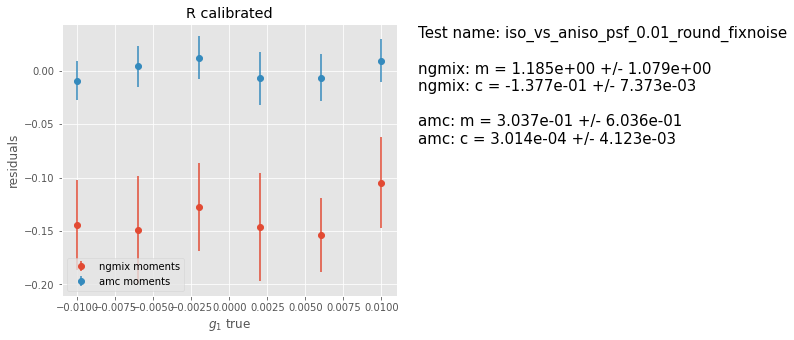

In [18]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shear_ngmix_list)[:,0]
Y1err = array(shear_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope-1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shear_amc_list)[:,0] 
Y1err = array(shear_err_amc_list)[:,0]

#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calibrated')
savefig(f'{results_folder}/uncorrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

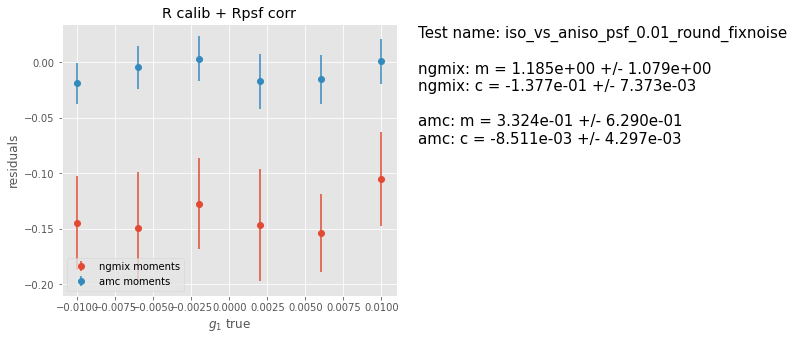

In [19]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shearcorr_ngmix_list)[:,0]
Y1err = array(shearcorr_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope - 1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"
plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shearcorr_amc_list)[:,0] 
Y1err = array(shearcorr_err_amc_list)[:,0]

#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calib + Rpsf corr')
savefig(f'{results_folder}/corrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

In [20]:
R_amc = result['amc']['R']
R_ngmix = result['ngmix']['R']
Rpsf_amc =result['amc']['Rpsf']
Rpsf_ngmix = result['ngmix']['Rpsf']

In [21]:
R_amc = tf.concat(R_amc_list,axis=0)
R_ngmix = tf.cast(tf.concat(R_ngmix_list,axis=0),dtype=tf.float32)
Rpsf_amc =tf.concat(Rpsf_amc_list,axis=0)
Rpsf_ngmix = tf.cast(tf.concat(Rpsf_ngmix_list,axis=0),dtype=tf.float32)

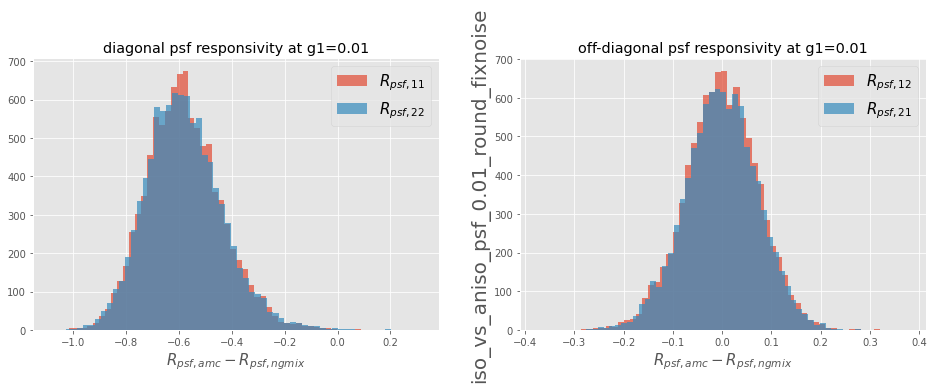

In [22]:
figure(figsize=(16,5))
subplot(121)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,11}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,22}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'diagonal psf responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,12}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,21}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'off-diagonal psf responsivity at g1={shear}')
savefig(f'{results_folder}/Rpsf_{settings_name}.jpg',bbox_inches='tight')

In [23]:
(Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten().mean()

-0.57839835

In [24]:
(Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten().std()

0.14198264

In [25]:
(Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten().mean()

-0.5784164

In [26]:
(Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten().std()

0.14482003

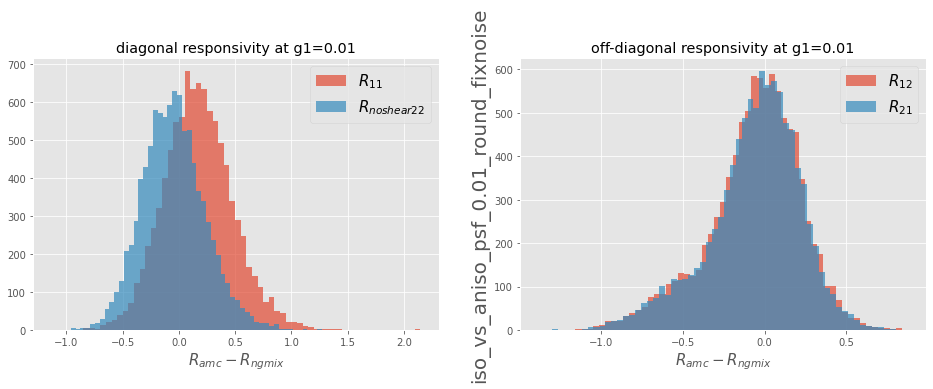

In [27]:
figure(figsize=(16,5))
subplot(121)
hist((R_amc - R_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{11}$');
hist((R_amc - R_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{noshear22}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'diagonal responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((R_amc - R_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{12}$');
hist((R_amc - R_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{21}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'off-diagonal responsivity at g1={shear}')
savefig(f'{results_folder}/R_{settings_name}.jpg',bbox_inches='tight')

In [28]:
banana();

NameError: name 'banana' is not defined

## Sensitivity Tests

In [30]:
def test_loop(noise_level,shear_points=6,fieldbatches=4):
  shear_range = linspace(-.01,.01,shear_points)

  shear_ngmix_list = []
  shear_err_ngmix_list = []
  shearcorr_ngmix_list = []
  shearcorr_err_ngmix_list = []
  R_ngmix_list = []
  Rpsf_ngmix_list = []

  shear_amc_list = []
  shear_err_amc_list = []
  shearcorr_amc_list = []
  shearcorr_err_amc_list = []
  R_amc_list = []
  Rpsf_amc_list = []
    
  for shear in shear_range:
    shear_true = array([shear,0.],dtype='float32')
    result = run_field(shear_true,g_psf,noise_level,fieldbatches)
    #ngmix
    shear_ngmix_list += [result['ngmix']['shear'] ] 
    shear_err_ngmix_list += [result['ngmix']['shear_err']]
    shearcorr_ngmix_list += [result['ngmix']['shearcorr']]
    shearcorr_err_ngmix_list += [result['ngmix']['shearcorr_err']]
    R_ngmix_list += [result['ngmix']['R']]
    Rpsf_ngmix_list += [result['ngmix']['Rpsf']]
    #amc   
    shear_amc_list += [result['amc']['shear']]
    shear_err_amc_list += [result['amc']['shear_err']]
    shearcorr_amc_list += [result['amc']['shearcorr']]
    shearcorr_err_amc_list += [result['amc']['shearcorr_err']]
    R_amc_list += [result['amc']['R']]
    Rpsf_amc_list += [result['amc']['Rpsf']]
  
  #g1
  #ngmix
  X1 = shear_range#[:,0]
  Y1_ngmix =  array(shearcorr_ngmix_list)[:,0]
  Y1err_ngmix = array(shearcorr_err_ngmix_list)[:,0]/abs(X1)
  g1_scatter_ngmix = Y1err_ngmix.mean()

  #biases
  ngmix_bias1 = linregress(X1,Y1_ngmix)
  m1_ngmix = ngmix_bias1.slope - 1
  c1_ngmix = ngmix_bias1.intercept

  #errors
  m1_ngmix_err = ngmix_bias.stderr
  c1_ngmix_err = ngmix_bias.intercept_stderr
  
  #amc
  Y1_amc =  array(shearcorr_amc_list)[:,0] 
  Y1err_amc = array(shearcorr_err_amc_list)[:,0]/abs(X1)
  g1_scatter_amc = Y1err_amc.mean()

  #biases
  amc_bias1 = linregress(X1,Y1_amc)
  m1_amc = amc_bias1.slope-1
  c1_amc = amc_bias1.intercept

  #errors
  m1_amc_err = amc_bias1.stderr
  c1_amc_err = amc_bias1.intercept_stderr
  
  #g2
  #X2 = shear_range#[:,1]
  #Y2_ngmix =  array(shearcorr_ngmix_list)[:,1]
  #Y1err_ngmix = array(shearcorr_err_ngmix_list)[:,1]

  #biases
  #ngmix_bias2 = linregress(X2,Y2_ngmix)
  #m2_ngmix = ngmix_bias2.slope - 1
  #c2_ngmix = ngmix_bias2.intercept

  #errors
  #m2_ngmix_err = ngmix_bias.stderr
  #c2_ngmix_err = ngmix_bias.intercept_stderr
  
  #Y2_amc =  array(shearcorr_amc_list)[:,1] 
  #Y1err_amc = array(shearcorr_err_amc_list)[:,0]

  #biases
  #amc_bias2 = linregress(X2,Y2_amc)
  #m2_amc = amc_bias2.slope-1
  #c2_amc = amc_bias2.intercept

  #errors
  #m2_amc_err = amc_bias.stderr
  #c2_amc_err = amc_bias.intercept_stderr
  
  result = {
    'm1_amc' :[m1_amc,m1_amc_err],
    'c1_amc' :[c1_amc,c1_amc_err], 
    'm1_ngmix' :[m1_ngmix,m1_ngmix_err],
    'c1_ngmix' :[c1_ngmix,c1_ngmix_err],
    'g1_scatter_amc' : g1_scatter_amc,
    'g1_scatter_ngmix' : g1_scatter_ngmix,
    #'m2_amc' :[m2_amc,m2_amc_err],
    #'c2_amc' :[c2_amc,c2_amc_err],
    #'m2_ngmix' :[m2_ngmix,m2_ngmix_err], 
    #'c2_ngmix' :[c2_ngmix,c2_ngmix_err],
  }
  
  return result

In [31]:
test_result_list = []
timestamp = time.time()
noises=logspace(-2,-3,8)
for noise_level in tqdm.tqdm(noises):
  test_result_list +=[test_loop(noise_level,fieldbatches=40)]
  save(f"sensetest_{settings_name}_{timestamp}.npy",test_result_list)  

100%|██████████| 8/8 [12:06:53<00:00, 5451.68s/it]  


test_result_list = load("sensetest_iso_vs_aniso_psf_1e-06_round_fixnoise_1659215738.4373617.npy",allow_pickle=True)

In [32]:
len(test_result_list)

8

In [39]:
m1_amc_list = [test_result['m1_amc'][0] for test_result in test_result_list]
m1_amc_list_err = [test_result['m1_amc'][1] for test_result in test_result_list]
m1_ngmix_list = [test_result['m1_ngmix'][0] for test_result in test_result_list]
m1_ngmix_list_err = [test_result['m1_ngmix'][1] for test_result in test_result_list]
g1_scatter_amc = [test_result['g1_scatter_amc'] for test_result in test_result_list]
g1_scatter_ngmix = [test_result['g1_scatter_ngmix'] for test_result in test_result_list]

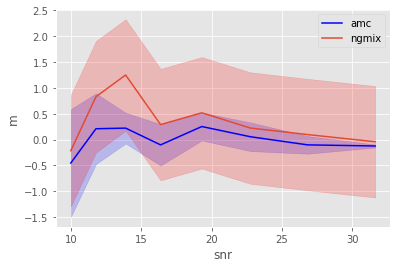

In [47]:
noises=logspace(-2,-3,8)[:len(test_result_list)]
X = 1/sqrt(noises)
Y = (array(m1_amc_list))
plot(X,Y,label='amc',color='b')
fill_between(X,Y-m1_amc_list_err,Y+m1_amc_list_err,color='blue',alpha=.2)
Y = (array(m1_ngmix_list))
plot(X,Y,label='ngmix')
fill_between(X,Y-m1_ngmix_list_err,Y+m1_ngmix_list_err,color='red',alpha=.2)


#yscale('log')
#xscale('log')
xlabel('snr')
ylabel('m')
legend()
savefig('sensitivity_m1.jpeg')

In [49]:
c1_amc_list = [test_result['c1_amc'][0] for test_result in test_result_list]
c1_amc_list_err = [test_result['c1_amc'][1] for test_result in test_result_list]
c1_ngmix_list = [test_result['c1_ngmix'][0] for test_result in test_result_list]
c1_ngmix_list_err = [test_result['c1_ngmix'][1] for test_result in test_result_list]

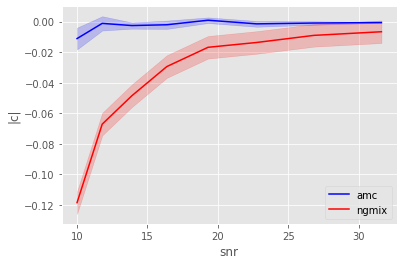

In [51]:
Y = (array(c1_amc_list))
plot(X,Y,label='amc',color='b')
fill_between(X,Y-c1_amc_list_err,Y+c1_amc_list_err,color='blue',alpha=.2)
Y = (array(c1_ngmix_list))
plot(X,Y,label='ngmix',color='r')
fill_between(X,Y-c1_ngmix_list_err,Y+c1_ngmix_list_err,color='red',alpha=.2)
#yscale('log')
#xscale('log')
xlabel('snr')
ylabel('|c|')
legend()
savefig('sensitivity_c1.jpeg')

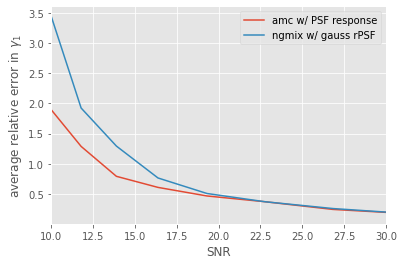

In [37]:
Y1 = abs(array(g1_scatter_amc))
Y2 = abs(array(g1_scatter_ngmix))
#plot([0,100],[1,1],'k')
plot(X,Y1,label='amc w/ PSF response')
plot(X,Y2,label='ngmix w/ gauss rPSF')
#yscale('log')
#xscale('log')
xlabel('SNR')
xlim([10,30])
ylabel('average relative error in $ \\gamma_1$')
legend()
savefig('sense_scatter.jpeg')